<!-- <center><img src="https://keras.io/img/logo-small.png" alt="Keras logo" width="100"><br/>
This starter notebook is provided by the Keras team.</center> -->

# Finetuning Gemma for Answering Python Questions
<!-- [KerasNLP](https://github.com/keras-team/keras-nlp) and [Keras](https://github.com/keras-team/keras) -->

Notebook edited by: Kimaya Kulkarni

<!-- > The objective of this competition is to build tools to assist Kaggle developers.

<div align="center">
    <img src="https://i.ibb.co/8xZNc32/Gemma.png">
</div> -->
<!--
In this competition, we are asked to create notebooks that demonstrate how to use the Gemma LLM to accomplish one or more of the following developer-oriented tasks:
1. Answer common questions about the Kaggle platform.
2. Explain or teach basic data science concepts.
3. Summarize Kaggle Solution write-ups.
4. Explain or teach concepts from Kaggle Solution write-ups.
5. **Answer common questions about the Python programming language.** -->

<!-- This notebook guides you through performing `"1. Answer common questions about the Kaggle platform"` task for the competition. As this task requires specific knowledge of Kaggle, we need precise information about Kaggle. To do so, I have created a dataset, ["Kaggle Docs"](https://www.kaggle.com/datasets/awsaf49/kaggle-docs), collecting data from [kaggle.com/docs](https://www.kaggle.com/docs/). To make things easier for the model, the data is curated to have Question-Answer pair format, but if you are interested, the raw data is also available. We will use this dataset to fine-tune **Gemma LLM** to answer questions about the Kaggle platform. -->
I have used the example notebook given and updated it to perform the task, Answering common questions about the Python Langauge. I have used a dataset available on kaggle (cleaned and reduced form) along with a dataset I made using various online resources including python documentation. Both datasets post cleaning consist of question - answer pairs used to tune the LLM.
<!--
<u>Fun fact</u>: This notebook is backend-agnostic, supporting TensorFlow, PyTorch, and JAX. However, the best performance can be achieved from `JAX`. Utilizing KerasNLP and Keras allows us to choose our preferred backend. Explore more details on [Keras](https://keras.io/keras_3/).

**Note**: For a more in-depth understanding of KerasNLP, refer to the [KerasNLP guides](https://keras.io/keras_nlp/). -->


# Install Libraries  

In [ ]:
# Install Keras 3 last. See https://keras.io/getting_started/ for more details.
# !pip install --upgrade "packaging~=23.1"
!pip install -q -U keras-nlp
!pip install -q -U keras>3

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.1.1 which is incompatible.
tensorflowjs 4.16.0 requires packaging~=23.1, but you have packaging 21.3 which is incompatible.


# Import Libraries

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "jax" # you can also use tensorflow or torch
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00" # avoid memory fragmentation on JAX backend.

import keras
import keras_nlp
import pandas as pd

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas() # progress bar for pandas

import plotly.graph_objs as go
import plotly.express as px
from IPython.display import display, Markdown

2024-03-24 23:59:37.772641: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 23:59:37.772738: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 23:59:37.911295: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Configuration

In [ ]:
class CFG:
    seed = 42
    dataset_path = "/kaggle/input/kaggle-docs/questions_answers"
    preset = "gemma_2b_en" # name of pretrained Gemma
    sequence_length = 512 # max size of input sequence for training
    batch_size = 1 # size of the input batch in training, x 2 as two GPUs
    epochs = 5 # number of epochs to train

# Reproducibility
Sets value for random seed to produce similar result in each run.

In [ ]:
keras.utils.set_random_seed(CFG.seed)


# Data

The project's dataset was carefully crafted by combining self-generated FAQs from Python resources with an extensive Kaggle Stack Overflow dataset, creating a rich compilation tailored for fine-tuning the Gemma language model, focused on Python programming support and analysis.

<!-- **Data Format:**

=
- This file includes:
    - `Question`: A question about the Kaggle platform
    - `Answer`: Answer to the question in markdown format
    - `Category`: The category into which the question falls, one of the nine mentioned on the `kaggle.com/docs` website.
    
> You can access the **raw** data from `./kaggle-docs/raw/`, where there are `.txt` files for each of the **nine** categories. -->

Cleaning Kaggle Dataset

In [ ]:
# each question in kaggle dataset is tagged by the topic, we only take those qns whose tag is python
tags_df = pd.read_csv('/kaggle/input/pythonquestions/Tags.csv')
python_tags = tags_df[tags_df['Tag'] == 'python']
python_ids = python_tags['Id'].unique()
#questions.csv is imported
questions_df = pd.read_csv('/kaggle/input/pythonquestions/Questions.csv', encoding='latin1')
#only tags which selected previously are kept
questions_df = questions_df[questions_df['Id'].isin(python_ids)]
#keep only columns we plan on using
questions_df = questions_df[['Id','Score', 'Title', 'Body' ]]
#clean data
questions_df['Body'] = questions_df['Body'].str.replace('<.*?>', '', regex=True)
#create new column for question
questions_df['question'] = questions_df['Title'] + ' ' + questions_df['Body']

#answers.csv
answers_df = pd.read_csv('/kaggle/input/pythonquestions/Answers.csv', encoding='latin1')
#only tags which selected previously are kept
answers_df = answers_df[answers_df['ParentId'].isin(python_ids)]
#max score ans is kept
idx = answers_df.groupby('ParentId')['Score'].idxmax()
answers_max_df = answers_df.loc[idx]
answers_max_df = answers_max_df[['ParentId','Score', 'Body' ]]
#clean text
answers_max_df['Body'] = answers_max_df['Body'].str.replace('<.*?>', '', regex=True)

#merge questions and answer dfs
df1 = pd.merge(questions_df, answers_max_df, left_on='Id', right_on='ParentId')
df1 = df1.sort_values(by='Score_y', ascending=False)
df1 = df1.drop(columns=['ParentId','Score_x','Score_y','Title', 'Body_x', 'Id' ])
df1.rename(columns={'Body_y': 'answer'}, inplace=True)
print(df1.head())

                                               question  \
962   What does the "yield" keyword do? What is the ...   
334   What is a metaclass in Python? What are metacl...   
4082  How to make a chain of function decorators in ...   
1874  Does Python have a ternary conditional operato...   
2662  Accessing the index in Python 'for' loops How ...   

                                                 answer  
962   To understand what yield does, you must unders...  
334   Classes as objects\n\nBefore understanding met...  
4082  If you are not into long explanations, see Pao...  
1874  Yes, it was added in version 2.5.\nThe syntax ...  
2662  Using an additional state variable, such as an...  


In [ ]:
# personal dataset built for the task
df2 = pd.read_csv('/kaggle/input/python-q-1/python_coding_questions.csv')
df2.head(2)
print(df2.columns)


Index(['question', 'answer'], dtype='object')


In [ ]:
#combine the datasets, choose how many samples to use for training, here we take 500
df_all = pd.concat([df2, df1], ignore_index=True)
print(df_all.head())
print(df_all.tail())
df = df_all.iloc[:500]
print(df.head())
print(df.tail())

                                        question  \
0                How to create a list in Python?   
1    How to iterate over a dictionary in Python?   
2  How to check if a key exists in a dictionary?   
3                 How to merge two dictionaries?   
4                  How to sort a list in Python?   

                                              answer  
0    Use square brackets, e.g., my_list = [1, 2, 3].  
1  Use .items() to iterate over key, value pairs,...  
2              Use 'in', e.g., 'if key in my_dict:'.  
3  Use the update() method or {**dict1, **dict2} ...  
4       Use the sorted() function or .sort() method.  
                                                 question  \
539333  First Python Code I installed the PyCharm and ...   
539334  I am creating some voice authentication system...   
539335  Using the return values of dynamic classes I h...   
539336  How to flatten a nested "homogeneous" list I h...   
539337  'NameError' in Python Program I'm working on

We'll use the following simple template to create prompts from question-answer pairs and category to feed text into the model:

```
Category: ...

Question: ...

Answer: ...
```

This template helps the model understand what you're asking and how to respond accurately. You can explore more advanced prompt templates for better results.

In [ ]:
#prompt template
template = "\n\nQuestion:\n{question}\n\nAnswer:\n{answer}"

In [ ]:
from tqdm.auto import tqdm
tqdm.pandas()

template = "\n\nQuestion:\n{question}\n\nAnswer:\n{answer}"

df["prompt"] = df.progress_apply(lambda row: template.format(
                                                    question=row['question'],
                                                    answer=row['answer']), axis=1)
data = df['prompt'].tolist()


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_35/3894174901.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["prompt"] = df.progress_apply(lambda row: template.format(


Let's examine a sample prompt. As the answers in our dataset are curated with **markdown** format, we will render the sample using `Markdown()` to properly visualize the formatting.

## Sample

In [ ]:
def colorize_text(text):
    for word, color in zip([ "question", "answer"], [ "red", "green"]):
        text = text.replace(f"\n\n{word}:", f"\n\n**<font color='{color}'>{word}:</font>**")
    return text

In [ ]:
# Take a random sample
sample = data[45]

# Give colors to Question, Answer and Category
sample = colorize_text(sample)

# Show sample in markdown
display(Markdown(sample))



Question:
How to reverse a list?

Answer:
Use the reverse() method or slicing [::-1].

# Exploratory Data Analysis

Let's do a simple EDA to determine how many question-answer pairs we have per category.

[   22    29    30    31    33    37    43    45    53    63    68    79
    86    88    91    98    99   101   102   104   105   107   109   111
   113   114   118   121   122   123   125   126   127   129   130   131
   137   142   143   144   145   147   148   149   150   152   153   154
   155   156   157   158   159   161   162   165   167   169   173   174
   175   178   179   180   181   183   184   185   186   187   188   189
   190   191   192   196   199   200   202   203   204   205   206   209
   211   212   213   216   217   218   219   223   225   227   229   231
   233   234   235   244   245   246   247   248   250   251   254   256
   257   258   259   260   262   263   264   266   268   269   272   274
   280   283   284   285   287   291   292   293   295   298   303   304
   305   311   316   318   319   320   322   323   328   330   332   333
   334   336   338   341   347   349   352   353   354   357   360   362
   369   370   372   376   378   379   382   383   

Text(0, 0.5, 'Count')

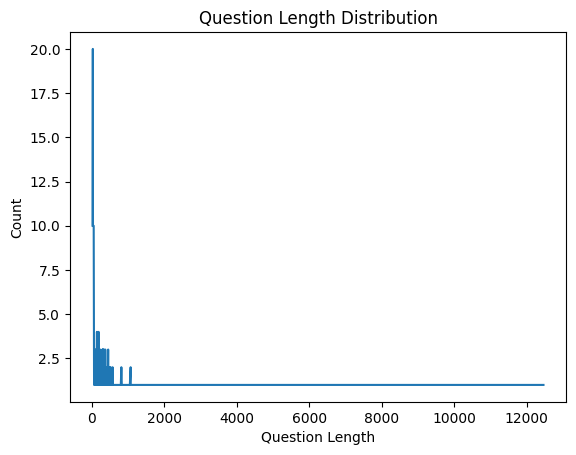

In [ ]:
# plot question length vs count distribution
df_copy = df.copy()
# Example assuming you want to analyze the length of questions
df_copy['QuestionLength'] = df_copy['question'].apply(len)

# Get unique lengths and their frequency
unique_lengths, length_counts = np.unique(df_copy['QuestionLength'], return_counts=True)

print(unique_lengths)
print(length_counts)
plt.plot(unique_lengths, length_counts)
plt.title("Question Length Distribution")
plt.xlabel("Question Length")
plt.ylabel("Count")


# Modeling

<!-- <div align="center"><img src="https://i.ibb.co/Bqg9w3g/Gemma-Logo-no-background.png" width="300"></div> -->

**Gemma** is a suite of advanced open models developed by **Google DeepMind** and other **Google teams**, derived from the same research and technology behind the **Gemini** models. They can be integrated into applications and run on various platforms including mobile devices and hosted services. Developers can customize Gemma models using tuning techniques to enhance their performance for specific tasks, offering more targeted and efficient generative AI solutions beyond text generation.

Gemma models are available in several sizes so you can build generative AI solutions based on your available computing resources, the capabilities you need, and where you want to run them.

| Parameters size | Tuned versions    | Intended platforms                 | Preset                 |
|-----------------|-------------------|------------------------------------|------------------------|
| 2B              | Pretrained        | Mobile devices and laptops         | `gemma_2b_en`          |
| 2B              | Instruction tuned | Mobile devices and laptops         | `gemma_instruct_2b_en` |
| 7B              | Pretrained        | Desktop computers and small servers| `gemma_7b_en`          |
| 7B              | Instruction tuned | Desktop computers and small servers| `gemma_instruct_7b_en` |

In this notebook, we will use the `Gemma 2B` from KerasNLP's pretrained models to answer questions about python programming.

<!-- To explore other models, simply modify the `preset` in the `CFG` (config). A list of other available pretrained models can be found on the [KerasNLP website](https://keras.io/api/keras_nlp/models/). -->



## Gemma Causal LM

The code below will build an end-to-end Gemma model for causal language modeling (hence the name `GemmaCausalLM`). A causal language model (LM) predicts the next token based on previous tokens. This task setup can be used to train the model unsupervised on plain text input or to autoregressively generate plain text similar to the data used for training. This task can be used for pre-training or fine-tuning a Gemma model simply by calling `fit()`.

This model has a `generate()` method, which generates text based on a prompt. The generation strategy used is controlled by an additional sampler argument on `compile()`. You can recompile the model with different `keras_nlp.samplers` objects to control the generation. By default, `"greedy"` sampling will be used.

> The `from_preset` method instantiates the model from a preset architecture and weights.

In [ ]:
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma_2b_en")
gemma_lm.summary()

Attaching 'config.json' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.spm' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle notebook...
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                   │                                             256,000 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,506,172,416 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,506,172,416 (9.34 GB)

 Trainable params: 2,506,172,416 (9.34 GB)

 Non-trainable params: 0 (0.00 B)

## Gemma LM Preprocessor

An important part of the Gemma model is the **Preprocessor** layer, which under the hood uses **Tokenizer**.

**What it does:** The preprocessor takes input strings and transforms them into a dictionary (`token_ids`, `padding_mask`) containing preprocessed tensors. This process starts with tokenization, where input strings are converted into sequences of token IDs.

**Why it's important:** Initially, raw text data is complex and challenging for modeling due to its high dimensionality. By converting text into a compact set of tokens, such as transforming `"The quick brown fox"` into `["the", "qu", "##ick", "br", "##own", "fox"]`, we simplify the data. Many models rely on special tokens and additional tensors to understand input. These tokens help divide input and identify padding, among other tasks. Making all sequences the same length through padding boosts computational efficiency, making subsequent steps smoother.

Explore the following pages to access the available preprocessing and tokenizer layers in **KerasNLP**:
- [Preprocessing](https://keras.io/api/keras_nlp/preprocessing_layers/)
- [Tokenizers](https://keras.io/api/keras_nlp/tokenizers/)

In [ ]:
x, y, sample_weight = gemma_lm.preprocessor(data[0:2])

This preprocessing layer will take in batches of strings, and return outputs in a `(x, y, sample_weight)` format, where the `y` label is the next token id in the `x` sequence.

From the code below, we can see that, after the preprocessor, the data shape is `(num_samples, sequence_length)`.

In [ ]:
# Display the shape of each processed output
for k, v in x.items():
    print(k, ":", v.shape)

token_ids : (2, 8192)
padding_mask : (2, 8192)


# Inference before fine tuning

Let's ask the Gemma model some sample questions using our prepared prompt and see how it responds.

> Our initial tests with the Gemma model on Python queries revealed a need for fine-tuning, as responses lacked precision and contextual relevance. Enhancing the model with a targeted dataset will improve its accuracy and utility in addressing programming-specific questions.

## Sample 1

In [ ]:
# Take one sample
row = df.iloc[2]

# Generate Prompt using template
prompt = template.format(

    question=row.question,
    answer=""
)

# Infer
output = gemma_lm.generate(prompt, max_length=256)

# Colorize
output = colorize_text(output)

# Display in markdown
display(Markdown(output))



Question:
How to check if a key exists in a dictionary?

Answer:
The in operator can be used to check if a key exists in a dictionary.

Example:

>>> d = {'a': 1, 'b': 2, 'c': 3}
>>> d.get('a')
1
>>> d.get('d')
>>> d.get('e')
>>> d.get('f')
>>> d.get('g')
>>> d.get('h')
>>> d.get('i')
>>> d.get('j')
>>> d.get('k')
>>> d.get('l')
>>> d.get('m')
>>> d.get('n')
>>> d.get('o')
>>> d.get('p')
>>> d.get('q')
>>> d.get('r')
>>> d.get('s')
>>> d.get('t')
>>> d.get('u')
>>> d.get('v')
>>> d.get('w')
>>> d.get('x')
>>> d.get('y')
>>> d.get('z')


## Sample 2

In [ ]:
# Take one sample
row = df.iloc[250]

# Generate Prompt using template
prompt = template.format(

    question=row.question,
    answer=""
)

# Infer
output = gemma_lm.generate(prompt, max_length=256)

# Colorize
output = colorize_text(output)

# Display in markdown
display(Markdown(output))



Question:
Python `if x is not None` or `if not x is None`? I've always thought of the if not x is None version to be more clear, but Google's style guide implies (based on this excerpt) that they use if x is not None. Is there any minor performance difference (I'm assuming not), and is there any case where one really doesn't fit (making the other a clear winner for my convention)?*

*I'm referring to any singleton, rather than just None.


  ...to compare singletons like
  None. Use is  or is not.



Answer:
The difference is that the first one is a comparison of the object itself, while the second one is a comparison of the object's identity.

The first one is more efficient, because it doesn't have to check the object's identity.

The second one is more efficient, because it doesn't have to check the object's identity.

The second one is more efficient, because it doesn't have to check the object's identity.

The second one is more efficient, because it doesn't have to check the object's identity.

The

# Fine-tuning with LoRA

To get better responses from the model, we will fine-tune the model with Low Rank Adaptation (LoRA) on the **Kaggle Docs** dataset.

**What exactly is LoRA?**

LoRA is a method used to fine-tune large language models (LLMs) in an efficient way. It involves freezing the weights of the LLM and injecting trainable rank-decomposition matrices.

Imagine in an LLM, we have a pre-trained dense layer, represented by a $d \times d$ weight matrix, denoted as $W_0$. We then initialize two additional dense layers, labeled as $A$ and $B$, with shapes $d \times r$ and $r \times d$, respectively. Here, $r$ denotes the rank, which is typically **much smaller than** $d$. Prior to LoRA, the model's output was computed using the equation $output = W_0 \cdot x + b_0$, where $x$ represents the input and $b_0$ denotes the bias term associated with the original dense layer, which remains frozen. After applying LoRA, the equation becomes $output = (W_0 \cdot x + b_0) + (B \cdot A \cdot x)$, where $A$ and $B$ denote the trainable rank-decomposition matrices that have been introduced.

<center><img src="https://i.ibb.co/DWsbhLg/LoRA.png" width="300"><br/>
Credit: <a href="https://arxiv.org/abs/2106.09685">LoRA: Low-Rank Adaptation of Large Language Models</a> Paper</center>


In the paper, $A$ is initialized with $\mathcal{N} (0, \sigma^2)$ and $B$ with $0$, where $\mathcal{N}$ denotes the normal distribution, and $\sigma^2$ is the variance.

**Why does LoRA save memory?**

Even though we're adding more layers to the model with LoRA, it actually helps save memory. This is because the smaller layers (A and B) have fewer parameters to learn compared to the big model and fewer trainable parameters mean fewer optimizer variables to store. So, even though the overall model might seem bigger, it's actually more efficient in terms of memory usage.

> This notebook uses a LoRA rank of `4`. A higher rank means more detailed changes are possible, but also means more trainable parameters.

In [ ]:
# Enable LoRA for the model and set the LoRA rank to 4.
gemma_lm.backbone.enable_lora(rank=4)
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                   │                                             256,000 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,507,536,384 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,507,536,384 (9.34 GB)

 Trainable params: 1,363,968 (5.20 MB)

 Non-trainable params: 2,506,172,416 (9.34 GB)

**Notice** that, the number of trainable parameters is reduced from ~$2.5$ billions to ~$1.3$ millions after enabling LoRA.

In [ ]:
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=5e-6,
    weight_decay=0.01,
)
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

## Training

In [ ]:
# Limit the input sequence length to 512 (to control memory usage).
gemma_lm.preprocessor.sequence_length = CFG.sequence_length

# Compile the model with loss, optimizer, and metric
gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# Train model
gemma_lm.fit(data, epochs=5, batch_size=CFG.batch_size)
# gemma_lm.fit(data, epochs=CFG.epochs, batch_size=CFG.batch_size)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 385s 728ms/step - loss: 0.5898 - sparse_categorical_accuracy: 0.5749
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 364s 727ms/step - loss: 0.5819 - sparse_categorical_accuracy: 0.5776
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 364s 727ms/step - loss: 0.5729 - sparse_categorical_accuracy: 0.5808
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 364s 727ms/step - loss: 0.5624 - sparse_categorical_accuracy: 0.6015
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 364s 727ms/step - loss: 0.5537 - sparse_categorical_accuracy: 0.6125


# Inference after fine-tuning

Let's see how our fine-tuned model responds to the same questions we asked before fine-tuning the model.

## Sample 1

In [ ]:
# Take one sample
row = df.iloc[2]

# Generate Prompt using template
prompt = template.format(

    question=row.question,
    answer=""
)

# Infer
output = gemma_lm.generate(prompt, max_length=256)

# Colorize
output = colorize_text(output)

# Display in markdown
display(Markdown(output))



Question:
How to check if a key exists in a dictionary?

Answer:
You can use either the .has_key() or the .get() methods to check if a key exists in a dictionary:

>>> d = {"a": 1, "b": 2}
>>> d.has_key("a") # Returns True
True
>>> d.has_key("c") # Returns False
False
>>> d.get("a") # If key doesn't exist, this will return a default value
>>> d.get("c") # If key doesn't exist, this will raise KeyError exception


Note that if a key doesn't exist in a dictionary, the get() method will return the default (if specified) for the key. If the default is not specified, the get() method will raise a KeyError exception.



## Sample 2

In [ ]:
# Take one sample
row = df.iloc[250]

# Generate Prompt using template
prompt = template.format(

    question=row.question,
    answer=""
)

# Infer
output = gemma_lm.generate(prompt, max_length=256)

# Colorize
output = colorize_text(output)

# Display in markdown
display(Markdown(output))



Question:
Python `if x is not None` or `if not x is None`? I've always thought of the if not x is None version to be more clear, but Google's style guide implies (based on this excerpt) that they use if x is not None. Is there any minor performance difference (I'm assuming not), and is there any case where one really doesn't fit (making the other a clear winner for my convention)?*

*I'm referring to any singleton, rather than just None.


  ...to compare singletons like
  None. Use is  or is not.



Answer:
The difference is only in speed, and only in Python.

If you're using an object, and you want to test if the reference to that object is None, then the first form of your if is faster than the second.

>>> import time
>>> x = object()
>>> t= time.time()
>>> x is None
>>> time.time() - t
0.000020
>>> t = time.time()
>>> x is not None
>>> time.time() - t
0.000023

## Unseen Sample

Also just for fun, let's try out a question that model hasn't seen during training.

In [ ]:
# Generate Prompt using template
prompt = template.format(

    question="How to export a notebook?",
    answer=""
)

# Infer
output = gemma_lm.generate(prompt, max_length=256)

# Colorize
output = colorize_text(output)

# Display in markdown
display(Markdown(output))



Question:
How to export a notebook?

Answer:
You can save a notebook by clicking the "Save" button at the bottom of the notebook. You can also export notebooks as a .nb file by clicking the "Save as" button.

Note that the "Save as" option will only work if you have a valid account. If you do not have a valid account, you can export notebooks as an HTML file by using the "Export to HTML" option in the "File" menu.

If you are using the JupyterHub notebook server, you can export notebooks as an HTML file using the "Save as HTML" button in the "File" menu.

Finally, you can also export notebooks as an XML file by using the "Export as XML" button in the "File" menu.

# Conclusion

The result is not bad, especially compared to the model without fine-tuning. It's important to remember that we only fine-tuned this model using $500$ samples without any augmentation or advanced prompting. Therefore, there is ample room for improvement. Here are some tips to improve performance:

- Increase number of samples used for finetuning
- Experiment with advanced prompt engineering techniques.
- Utilize a learning rate scheduler.

# Reference
* [Fine-tune Gemma models in Keras using LoRA](https://www.kaggle.com/code/nilaychauhan/fine-tune-gemma-models-in-keras-using-lora)
* [Parameter-efficient fine-tuning of GPT-2 with LoRA](https://keras.io/examples/nlp/parameter_efficient_finetuning_of_gpt2_with_lora/)
* [Gemma - KerasNLP](https://keras.io/api/keras_nlp/models/gemma/)
* [Python Questions from Stack Overflow](https://www.kaggle.com/datasets/stackoverflow/pythonquestions)